In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.ndimage import shift, zoom


In [ ]:
'''

t1_path = r"C:\Users\rreyt\Downloads\100307_3T_Structural_preproc\100307\T1w\T1w_acpc_dc_restore.nii.gz"
t2_path = r"C:\Users\rreyt\Downloads\100307_3T_Structural_preproc\100307\T1w\T2w_acpc_dc_restore.nii.gz"

t1_img = nib.load(t1_path)
t2_img = nib.load(t2_path)

t1_data = t1_img.get_fdata()
t2_data = t2_img.get_fdata()

mid = t1_data.shape[2] // 2

t1_slice = t1_data[:,:, mid]
t2_slice = t2_data[:,:, mid]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(t1_slice, cmap='gray')
plt.title('T1w')

plt.subplot(1, 2, 2)
plt.imshow(t2_slice, cmap='gray')
plt.title('T2w')

plt.tight_layout()
plt.show()

'''

In [95]:



t2_path = r'C:\Users\rreyt\Downloads\BIOE484_FinalProject\IXI-T2\IXI516-HH-2297-T2.nii\IXI516-HH-2297-DE3Diso_-s3T223_-0401-00004-000002-02.nii'
t1_path = r'C:\Users\rreyt\Downloads\BIOE484_FinalProject\IXI-T1\IXI516-HH-2297-T1.nii\IXI516-HH-2297-MADisoTFE1_-s3T223_-0301-00003-000001-01.nii'


t2_img = nib.load(t2_path)
t1_img = nib.load(t1_path)


t2_data = t2_img.get_fdata()
t1_data = t1_img.get_fdata()


print('T2 shape:', t2_data.shape)
print('T1 shape:', t1_data.shape)






T2 shape: (256, 256, 130)
T1 shape: (256, 256, 150)


In [96]:
#Code to obtain the corresponding slices since the slicing indexes arnt the same

t2_slice_idx = 70
t2_aff = t2_img.affine
t1_aff = t1_img.affine


t2_voxel = np.array([t2_data.shape[0]//2, t2_data.shape[1]//2, t2_slice_idx, 1])
t2_world = t2_aff @ t2_voxel  # Gives (x, y, z, 1)
t2_z_mm = t2_world[2]


t1_voxel = np.linalg.inv(t1_aff) @ t2_world
t1_slice_idx = int(round(t1_voxel[1])) 

print('Matching T1 slice index:', t1_slice_idx)


Matching T1 slice index: 151


In [97]:


t2_slice = t2_data[:,:, t2_slice_idx]

t1_slice_idx = 151
t1_slice = t1_data[:, t1_slice_idx, :]



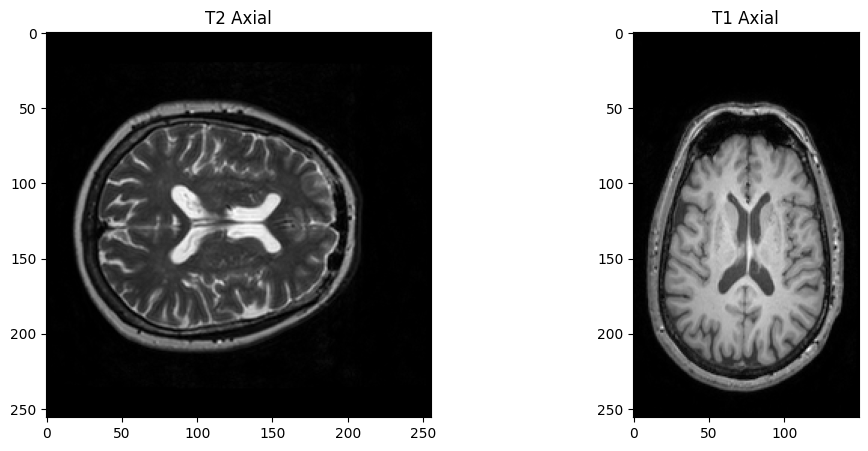

In [99]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(t2_slice, cmap='gray')
plt.title('T2 Axial')

plt.subplot(1, 2, 2)
plt.imshow(t1_slice, cmap='gray')
plt.title('T1 Axial')
plt.show()

In [101]:
t1_slice = np.rot90(t1_slice)
t1_slice = np.fliplr(t1_slice)

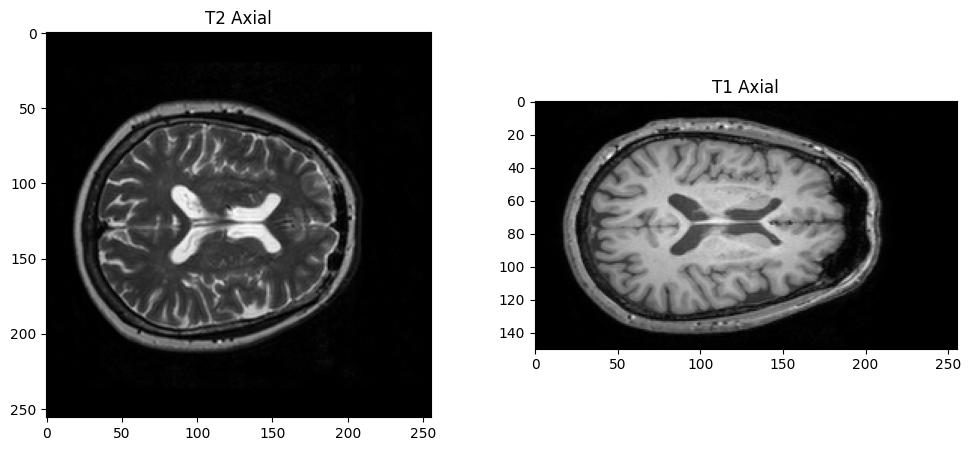

In [102]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(t2_slice, cmap='gray')
plt.title('T2 Axial')

plt.subplot(1, 2, 2)
plt.imshow(t1_slice, cmap='gray')
plt.title('T1 Axial')
plt.show()


In [6]:
print('T2 slice shape:', t2_slice.shape)
print('T1 slice shape:', t1_slice.shape)


T2 slice shape: (256, 256)
T1 slice shape: (150, 256)


In [7]:

def joint_histogram(image_A, image_B, bins = 64): 

    A_samples = image_A.flatten() #Flatten to then treat the voxels as samples from the random variable (the image)
    B_samples = image_B.flatten()

    joint_hist, A_boundary, B_boundary = np.histogram2d(A_samples, B_samples, bins = bins) 
    #Creating joint histogram from joint probablity of Image A and Image B. A and Boundaries are variables that store intensity value in thesholds from A and B samples.

    return joint_hist
    


In [8]:
def crop_overlap(image_A, image_B): 
    h = min(image_A.shape[0], image_B.shape[0])
    w = min(image_A.shape[1], image_B.shape[1]) 
    return image_A[:h, :w], image_B[:h,:w]

In [9]:
t1_crop, t2_crop = crop_overlap(t1_slice, t2_slice) 

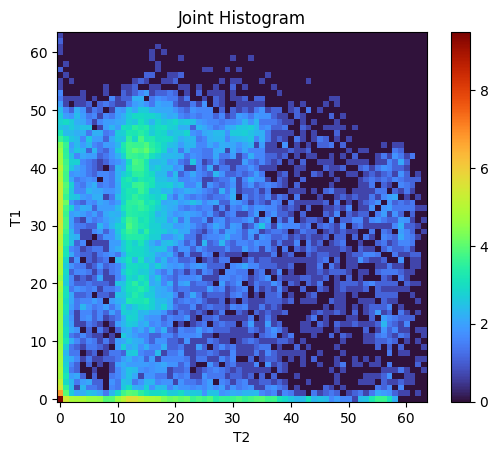

In [10]:
joint_hist = joint_histogram(t1_crop, t2_crop, bins = 64) 
joint_hist_log = np.log1p(joint_hist)

vmax = np.max(joint_hist_log)
plt.imshow(joint_hist_log, cmap = 'turbo', origin = 'lower', vmax = vmax, interpolation = 'nearest') 
plt.title('Joint Histogram')
plt.xlabel('T2')
plt.ylabel('T1')
plt.colorbar()
plt.show()

In [45]:
'''

In practice we do not know the probability distribution of the image. So we sample the joint distribution using a 2d histogram to obtain an estimate of the joint distribution. 
then by normalizing we can get the marginal (the distrubution of image A and B independently)

Steps: 

Obtain Samples: Flattened Image to get Voxel values
Estimate Joint freqeuncies: 2d histogram
Obtain Joint Probability: Normalization
Obtain Marignal Distribution: Sum over rows and columns

'''

'\n\nIn practice we do not know the probability distribution of the image. So we sample the joint distribution using a 2d histogram to obtain an estimate of the joint distribution. \nthen my normalizing we can get the marginal (the distrubution of image A and B independently)\n\nSteps: \n\nObtain Samples: Flattened Image to get Voxel values\nEstimate Joint freqeuncies: 2d histogram\nObtain Joint Probability: Normalization\nObtain Marignal Distribution: Sum over rows and columns\n\n'

In [11]:
def normalize_histogram(hist): 
    x = hist / np.sum(hist) 
    return x 

In [12]:
joint_prob = normalize_histogram(joint_hist) 

In [13]:
ProbA = np.sum(joint_prob, axis = 1)  #summing across rows to get probability of A
ProbB = np.sum(joint_prob, axis = 0) #summing across columns to get probability of B


In [14]:
eps = 1e-10

H_A = -np.sum(ProbA * np.log(ProbA + eps)) #Computing entropy H(A) (Equation given from class)
H_B = -np.sum(ProbB * np.log(ProbB + eps)) #Computing entropy H(B) 

print(H_A)
print(H_B)

2.873161077149753
2.4194796237990728


In [15]:
ProbA_GivenB = joint_prob / (ProbB[np.newaxis, :] + eps) #Using conditional probality equation. np.newaxis is used to make ProbB a row vector (shape match) 

H_A_GivenBm = -np.sum(ProbA_GivenB * np.log(ProbA_GivenB + eps), axis = 0) #summing over rows (where A_boundary is)

H_A_GivenB = np.sum(ProbB * H_A_GivenBm)

print(f'H(A | B): {H_A_GivenB}')

H(A | B): 2.665809246444995


In [16]:
#Compute Mutual information then maximize

MI = H_A - H_A_GivenB
print(f'Mutual Information: {MI}') 

Mutual Information: 0.20735183070475793


In [52]:
#shift t2 image for simulation
'''
t2_shift = (25, -30)

t2_misaligned = shift(t2_slice, shift = t2_shift, mode = 'nearest') 
'''

"\nt2_shift = (25, -30)\n\nt2_misaligned = shift(t2_slice, shift = t2_shift, mode = 'nearest') \n"

In [53]:
'''
fig,axs = plt.subplots(1,2,figsize = (15,5))

axs[0].imshow(t1_slice, cmap = 'gray') 
axs[0].set_title('T1 Image') 

axs[1].imshow(t2_misaligned, cmap = 'gray') 
axs[1].set_title('T2 Image') 

'''

"\nfig,axs = plt.subplots(1,2,figsize = (15,5))\n\naxs[0].imshow(t1_slice, cmap = 'gray') \naxs[0].set_title('T1 Image') \n\naxs[1].imshow(t2_misaligned, cmap = 'gray') \naxs[1].set_title('T2 Image') \n\n"

In [17]:
def pad_to_shape(image, target_shape):
    padded = np.zeros(target_shape, dtype=image.dtype)
    padded[:image.shape[0], :image.shape[1]] = image
    return padded

h = max(t2_slice.shape[0], t1_slice.shape[0])
w = max(t2_slice.shape[1], t1_slice.shape[1])
target_shape = (h, w)


t1_padded = pad_to_shape(t1_slice, target_shape)

In [18]:
print('T2 slice shape:', t2_slice.shape)
print('T1 slice shape:', t1_slice.shape)
print('T1 padded shape:', t1_padded.shape)


T2 slice shape: (256, 256)
T1 slice shape: (150, 256)
T1 padded shape: (256, 256)


In [33]:
MI_values = []
shift_values = []
scale_values = []
x_shifts = range(-40,41) #only shifting image by 40 pixels left or right
y_shifts = range(-40,41)
best_shift = (0,0)
x_scales = np.linspace(0.9,1.5,13)
y_scales = np.linspace(0.9, 1.5, 13)
best_scale = (1.0,1.0)
best_MI = -np.inf

for y_scale in y_scales:
    for x_scale in x_scales:
        t1_scaled = zoom(t1_padded, zoom = (y_scale,x_scale), order =1)
        for i, dy in enumerate(y_shifts):
            for j, dx in enumerate(x_shifts):
        
                shift_t1 = shift(t1_scaled, shift = (dy, dx), mode = 'nearest')

                image_A_crop, image_B_crop = crop_overlap(shift_t1, t2_slice) 

                joint_hist = joint_histogram(image_A_crop, image_B_crop, bins = 64)
                joint_prob = normalize_histogram(joint_hist) 
                ProbA = np.sum(joint_prob, axis = 1)  #summing across rows to get probability of A
                ProbB = np.sum(joint_prob, axis = 0) #summing across columns to get probability of B
                eps = 1e-10
                H_A = -np.sum(ProbA * np.log(ProbA + eps)) #Computing entropy H(A) (Equation given from class)
                H_B = -np.sum(ProbB * np.log(ProbB + eps)) #Computing entropy H(B) 
                ProbA_GivenB = joint_prob / (ProbB[np.newaxis, :] + eps) #Using conditional probality equation. np.newaxis is used to make ProbB a row vector (shape match) 
                H_A_GivenBm = -np.sum(ProbA_GivenB * np.log(ProbA_GivenB + eps), axis = 0) #summing over rows (where A_boundary is)
                H_A_GivenB = np.sum(ProbB * H_A_GivenBm)
                MI = H_A - H_A_GivenB
                MI_values.append(MI)
                shift_values.append((dy,dx))
                scale_values.append((y_scale, x_scale))

                if MI > best_MI: 
                    best_MI = MI
                    best_shift = (dy,dx)
                    best_scale = (y_scale, x_scale)

In [65]:
print(f'Best MI: {best_MI:.4f}') 
print(f'Best shift: dy = {best_shift[0]} and dx = {best_shift[1]}')
print(f'Best scale: y scale = {best_scale[0]:.4f} and x scale = {best_scale[1]:.4f}')

Best MI: 0.6901
Best shift: dy = 31 and dx = 1
Best scale: y scale = 1.3000 and x scale = 1.0000


In [82]:
#Heatmap Visualization

misT1, misT2 = crop_overlap(t1_slice, t2_slice) 
joint_hist1 = joint_histogram(misT1, misT2, bins = 64)

alignedT1 = shift(t1_padded, shift = best_shift, mode = 'nearest') 
alignedT1 = zoom(alignedT1, zoom = best_scale, order =1)
crop_aT1, crop_aT2 = crop_overlap(alignedT1, t2_slice) 
joint_hist2 = joint_histogram(crop_aT1, crop_aT2, bins = 64)

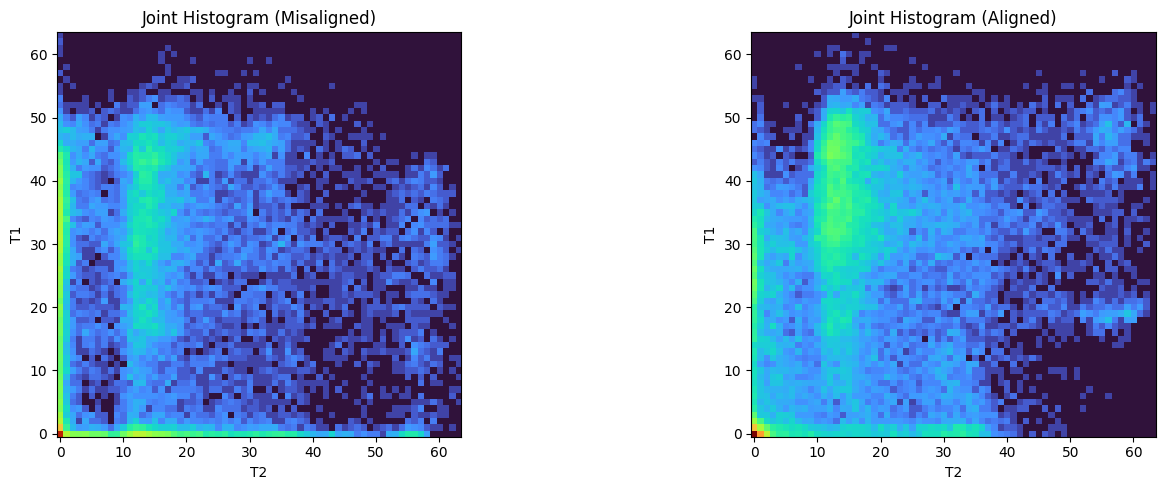

In [83]:
joint_hist1_log = np.log1p(joint_hist1)
joint_hist2_log = np.log1p(joint_hist2) 

vmax = max(np.max(joint_hist1_log),np.max(joint_hist2_log))

fig, axs = plt.subplots(1,2, figsize = (15,5)) 

axs[0].imshow(joint_hist1_log, cmap = 'turbo', origin = 'lower', vmax = vmax, interpolation = 'nearest')
axs[0].set_title('Joint Histogram (Misaligned)')
axs[0].set_xlabel('T2')
axs[0].set_ylabel('T1') 

axs[1].imshow(joint_hist2_log, cmap = 'turbo', origin = 'lower', vmax = vmax, interpolation = 'nearest') 
axs[1].set_title('Joint Histogram (Aligned)') 
axs[1].set_xlabel('T2')
axs[1].set_ylabel('T1') 

plt.tight_layout()
plt.show()

In [84]:

t2_padded = pad_to_shape(t2_slice, target_shape)


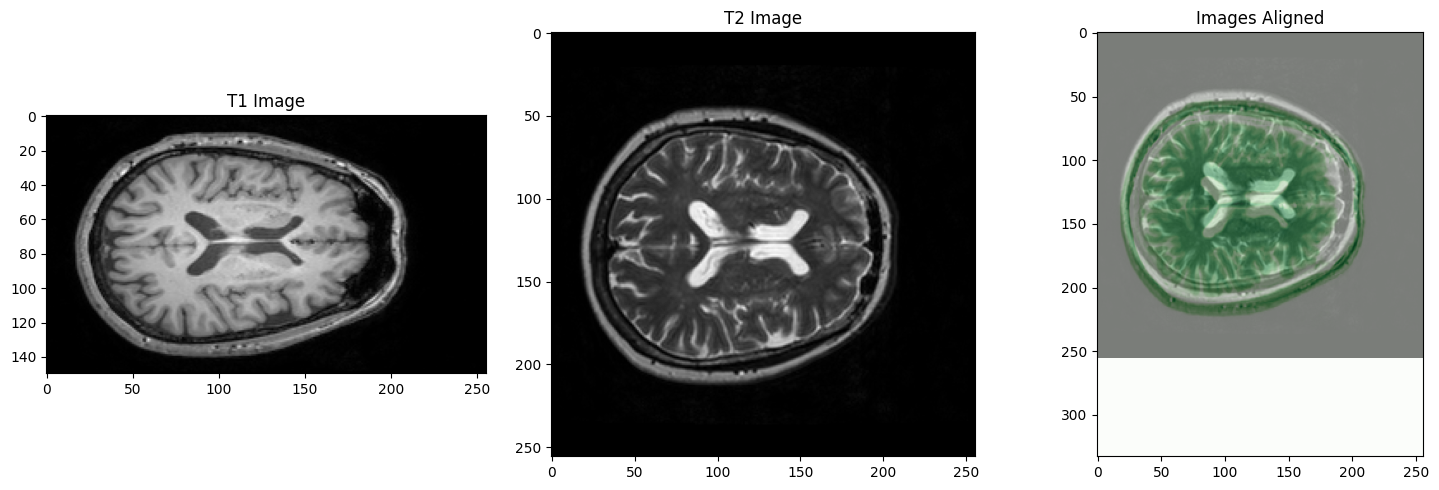

In [85]:
fig, axs = plt.subplots(1,3,figsize = (15,5))

axs[0].imshow(t1_slice, cmap = 'gray') 
axs[0].set_title('T1 Image') 

axs[1].imshow(t2_slice, cmap = 'gray') 
axs[1].set_title('T2 Image') 


axs[2].imshow(t2_padded, cmap='gray')
axs[2].imshow(alignedT1, cmap='Greens', alpha=0.5)
axs[2].set_title('Images Aligned')

plt.tight_layout()
plt.show()

In [47]:

from mpl_toolkits.mplot3d import Axes3D


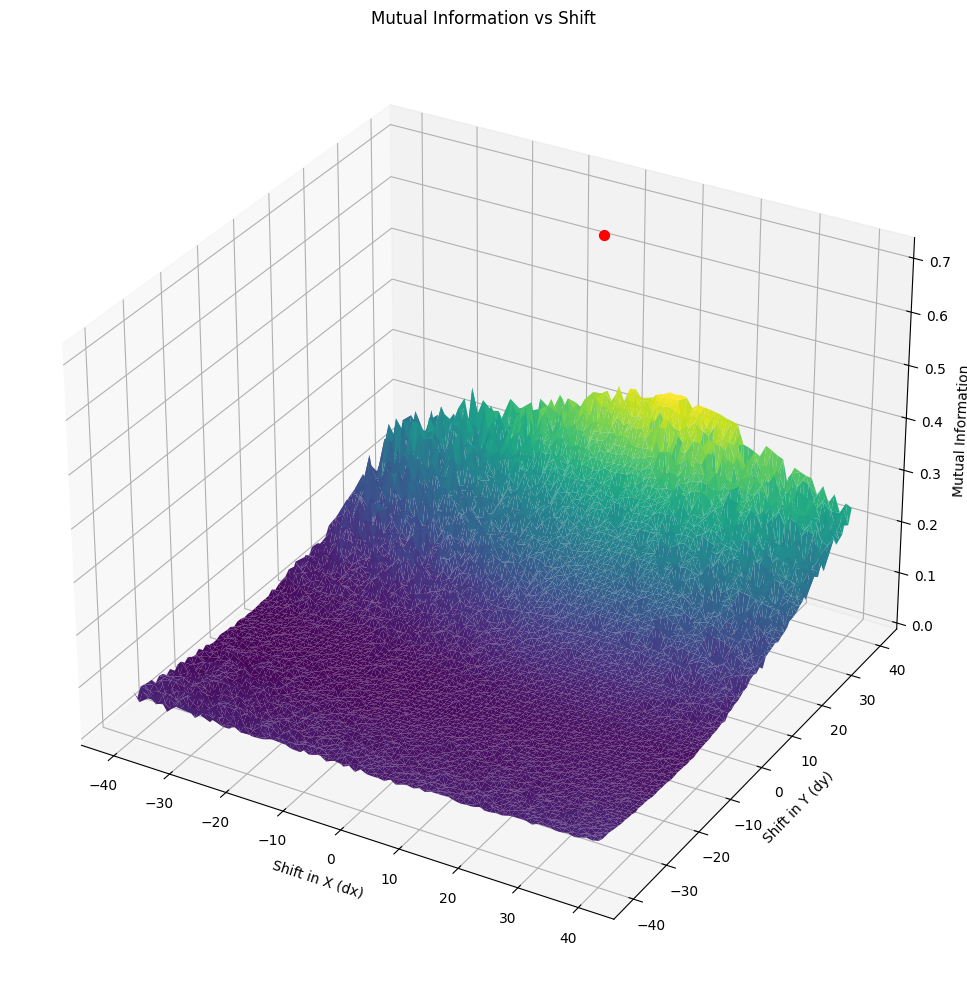

In [54]:

dy_vals = [dy for dy, dx in shift_values]
dx_vals = [dx for dy, dx in shift_values]
MI_array = np.array(MI_values)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(dx_vals, dy_vals, MI_array, cmap='viridis', edgecolor='none')
ax.scatter(
    [best_shift[1]],  
    [best_shift[0]],  
    [best_MI],        
    color='red',
    s=50,
    label='Best MI'
)

ax.set_title('Mutual Information vs Shift')
ax.set_xlabel('Shift in X (dx)')
ax.set_ylabel('Shift in Y (dy)')
ax.set_zlabel('Mutual Information')

plt.tight_layout()
plt.show()


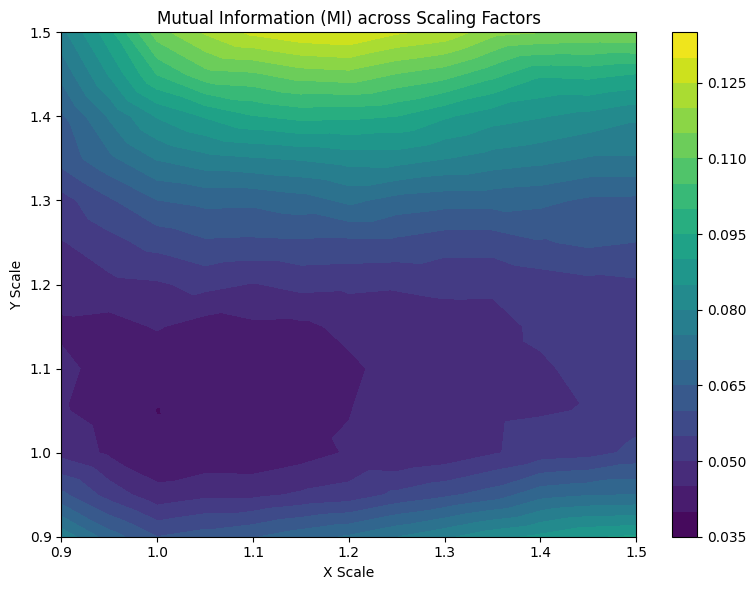

In [56]:

xscales = [s[1] for s in scale_values]
yscales = [s[0] for s in scale_values]
MI_array = np.array(MI_values)

fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.tricontourf(xscales, yscales, MI_array, levels=20, cmap='viridis')
plt.colorbar(contour)
ax.set_title('Mutual Information (MI) across Scaling Factors')
ax.set_xlabel('X Scale')
ax.set_ylabel('Y Scale')
plt.tight_layout()
plt.show()



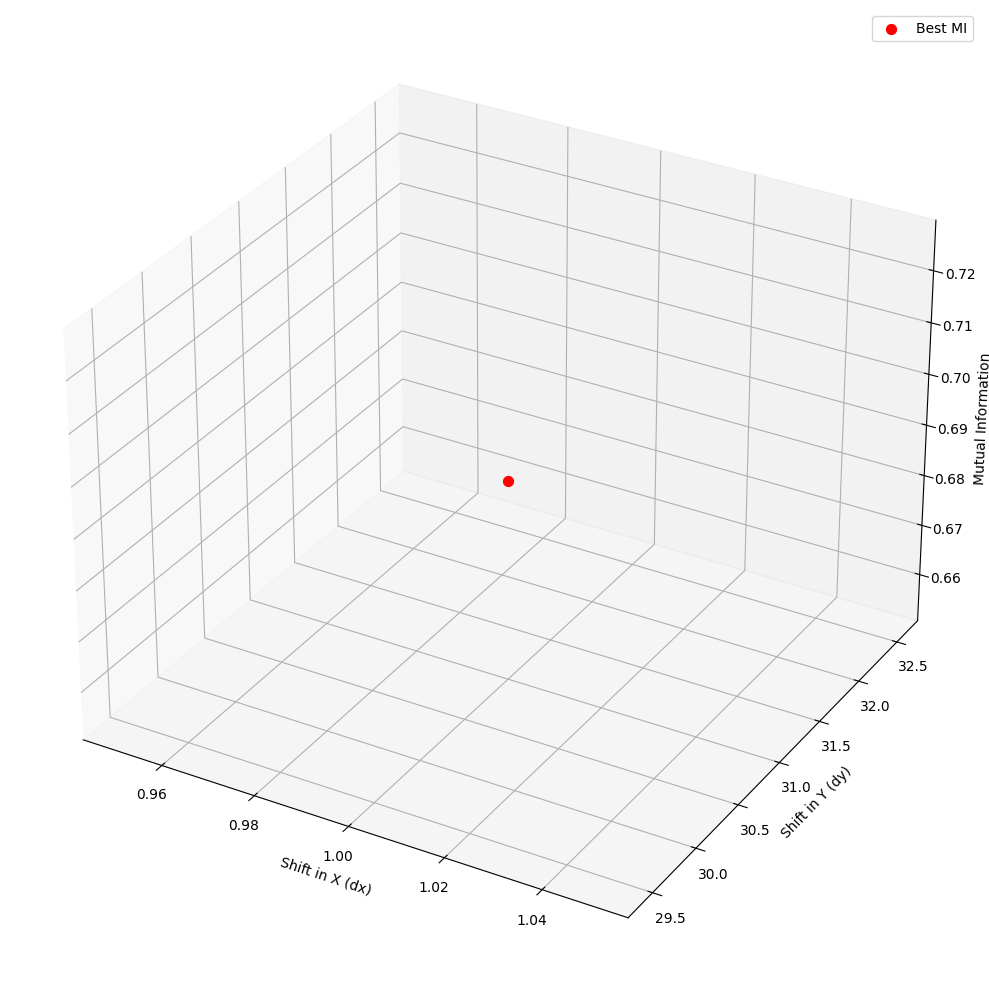

In [88]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(
    [best_shift[1]],  
    [best_shift[0]],  
    [best_MI],        
    color='red',
    s=50,
    label='Best MI'
)

ax.set_xlabel('Shift in X (dx)')
ax.set_ylabel('Shift in Y (dy)')
ax.set_zlabel('Mutual Information')
ax.legend()
plt.tight_layout()
plt.show()

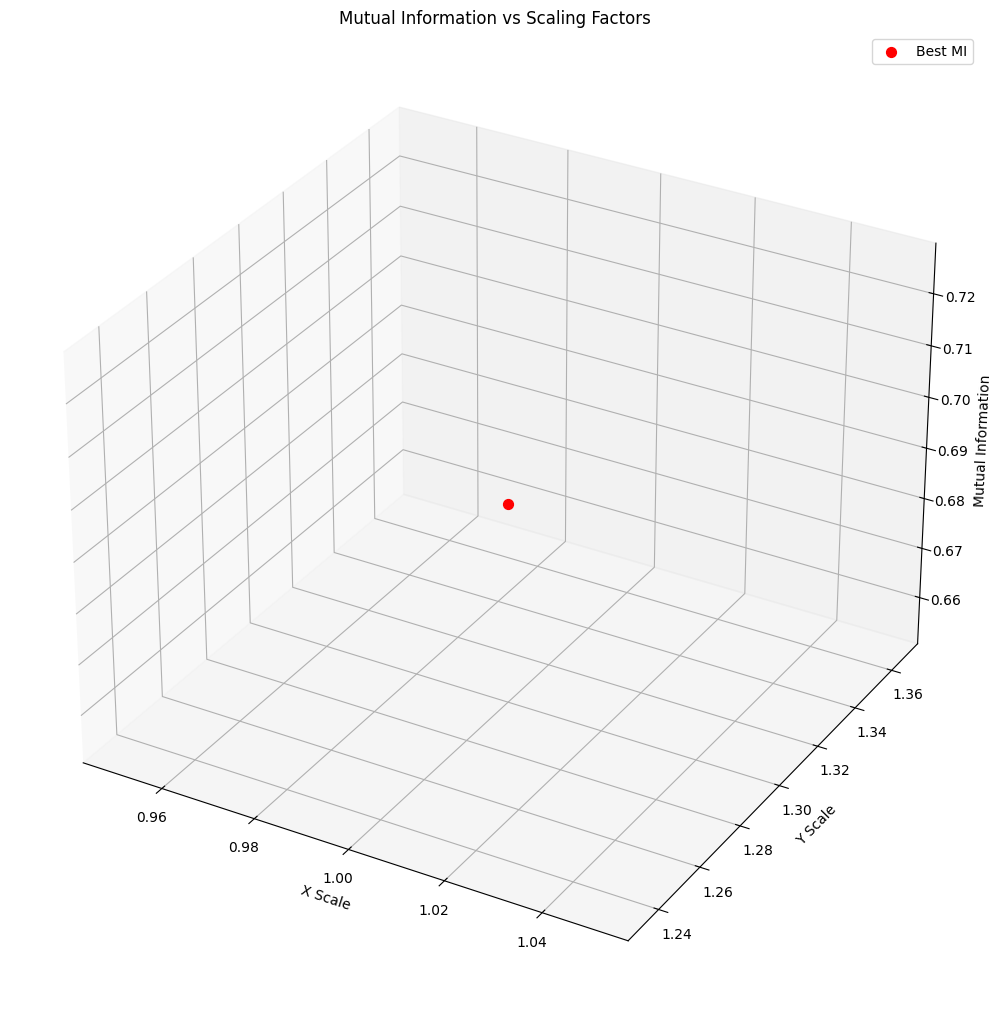

In [94]:


fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection='3d')



ax.scatter(
    [best_scale[1]], [best_scale[0]], [best_MI],
    color='red', s=50, label='Best MI'
)

ax.set_title('Mutual Information vs Scaling Factors')
ax.set_xlabel('X Scale')
ax.set_ylabel('Y Scale')
ax.set_zlabel('Mutual Information')
ax.legend()
plt.tight_layout()
plt.show()
